In [79]:
# General setup
import pandas as pd
import numpy as np

# Modeling tools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Preprocessing and scoring
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report, average_precision_score

# Visualization
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image  
from sklearn import tree
import pydotplus
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
bgg = pd.read_csv('data/bgg14_19.csv', index_col=0)
bgg.head()

FileNotFoundError: File b'data/bgg14_19.csv' does not exist

In [104]:
bgg_real_ratings = pd.read_csv('data/bgg_correct_ratings.csv', index_col=0)
bgg_real_ratings.head()

,Name,geek,avg,num_rev
0,Gloomhaven,8.610,8.90,25210.0
1,Scythe,8.118,8.28,39867.0
2,Terraforming Mars,8.243,8.40,39240.0
3,Arkham Horror: The Card Game,7.919,8.22,17646.0
4,Kingdom Death: Monster,7.808,8.80,5887.0


In [91]:
# Double checking that it pulled only those for the correct year
len(bgg[bgg['year'] < 2015]), len(bgg)


(249, 4902)

Looks like the API request either pulled the wrong games because of duplicate titles, or there was something else funky happening (potentially a revised version of an older game and it did not pull in details for the correct copy.  Because there is so few, we dropped those 

In [2]:
df = pd.read_csv('data/bgg_db_2018_01.csv', encoding='iso-8859-1')

In [3]:
df.head()

,rank,bgg_url,game_id,names,min_players,max_players,avg_time,min_time,max_time,year,avg_rating,geek_rating,num_votes,image_url,age,mechanic,owned,category,designer,weight
0,1,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,150,90,150,2017,9.01310,8.52234,9841,https://cf.geekdo-images.com/images/pic2437871...,12,"Action / Movement Programming, Co-operative Pl...",18217,"Adventure, Exploration, Fantasy, Fighting, Min...",Isaac Childres,3.7720
1,2,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60,60,60,2015,8.66575,8.49837,23489,https://cf.geekdo-images.com/images/pic2452831...,13,"Action Point Allowance System, Co-operative Pl...",38105,"Environmental, Medical","Rob Daviau, Matt Leacock",2.8056
2,3,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,2015,8.65702,8.32401,10679,https://cf.geekdo-images.com/images/pic2663291...,14,"Action Point Allowance System, Auction/Bidding...",14147,"Card Game, Civilization, Economic",Vlaada Chvátil,4.3538
3,4,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180,120,180,2005,8.35188,8.21012,29923,https://cf.geekdo-images.com/images/pic361592.jpg,13,"Area Control / Area Influence, Campaign / Batt...",41094,"Modern Warfare, Political, Wargame","Ananda Gupta, Jason Matthews",3.5446
4,5,https://boardgamegeek.com/boardgame/167791/ter...,167791,Terraforming Mars,1,5,120,120,120,2016,8.38331,8.17328,20468,https://cf.geekdo-images.com/images/pic3536616...,12,"Card Drafting, Hand Management, Tile Placement...",26145,"Economic, Environmental, Industry / Manufactur...",Jacob Fryxelius,3.2465


In [4]:
df['mechanic'] = df['mechanic'].apply(lambda x: [m for m in x.split(", ")])
df['category'] = df['category'].apply(lambda x: [c for c in x.split(", ")])

In [5]:
mechanics = df['mechanic'].tolist()
categories = df['category'].tolist()

In [6]:
mechanic_cols = sorted(set([val for sublist in mechanics for val in sublist]))
category_cols = sorted(set([val for sublist in categories for val in sublist]))
len(mechanic_cols), len(category_cols)

(52, 84)

In [199]:
# mech_cols = []
# for col in mechanic_cols:
#     disp_name = col.lower().replace("/","").replace(" ","_")
#     mech_cols.append('mech_' + disp_name)
#     df['mech_' + disp_name] = 0
#     col_names.append('mech_' + disp_name)

In [99]:
cat_cols = []
for col in category_cols:
    disp_name = col.lower().replace("/","").replace(" ","_")
    cat_cols.append('cat_' + disp_name)
#     df['cat_' + disp_name] = 0
#     col_names.append('cat_' + disp_name)

In [197]:
# mech_cols = []
# for mech in mechanic_cols:
#     disp_name = mech.lower().replace("/","").replace(" ","_")
#     for idx, row in df.iterrows():
#         if mech in row['mechanic']:
#             df['mech_' + disp_name][idx] = 1

In [200]:
# for cat in category_cols:
#     disp_name = cat.lower().replace("/","").replace(" ","_")
#     for idx, row in df.iterrows():
#         if cat in row['category']:
#             df['cat_' + disp_name][idx] = 1

In [47]:
df.drop(['bgg_url', 'year', 'avg_rating',
       'num_votes', 'image_url', 'owned', 'designer'], axis=1, inplace=True)

In [55]:
df.to_csv('data/bgg_binned_2018.csv')

### Prepping for testing

In [7]:
bgg = pd.read_csv('data/bgg_binned_2018.csv', index_col=0)

In [8]:
bgg.columns

Index(['rank', 'game_id', 'names', 'min_players', 'max_players', 'avg_time',
       'min_time', 'max_time', 'geek_rating', 'age',
       ...
       'cat_travel', 'cat_trivia', 'cat_video_game_theme', 'cat_vietnam_war',
       'cat_wargame', 'cat_word_game', 'cat_world_war_i', 'cat_world_war_ii',
       'cat_zombies', 'cat_none'],
      dtype='object', length=149)

In [9]:
bgg['geek_rating'].describe()

count    4999.000000
mean        6.082797
std         0.482280
min         5.636190
25%         5.720640
50%         5.901470
75%         6.289785
max         8.522340
Name: geek_rating, dtype: float64

In [10]:
bgg['top_score'] = bgg['geek_rating'].apply(lambda x: 1 if x > 6.289785 else 0)

In [11]:
bgg.head()

,rank,game_id,names,min_players,max_players,avg_time,min_time,max_time,geek_rating,age,...,cat_trivia,cat_video_game_theme,cat_vietnam_war,cat_wargame,cat_word_game,cat_world_war_i,cat_world_war_ii,cat_zombies,cat_none,top_score
0,1,174430,Gloomhaven,1,4,150,90,150,8.52234,12,...,0,0,0,0,0,0,0,0,0,1
1,2,161936,Pandemic Legacy: Season 1,2,4,60,60,60,8.49837,13,...,0,0,0,0,0,0,0,0,0,1
2,3,182028,Through the Ages: A New Story of Civilization,2,4,240,180,240,8.32401,14,...,0,0,0,0,0,0,0,0,0,1
3,4,12333,Twilight Struggle,2,2,180,120,180,8.21012,13,...,0,0,0,1,0,0,0,0,0,1
4,5,167791,Terraforming Mars,1,5,120,120,120,8.17328,12,...,0,0,0,0,0,0,0,0,0,1


In [12]:
drop = ['rank', 'game_id', 'names', 'geek_rating', 'age',
              'avg_time', 'top_score', 'category','mechanic']

# drop = ['rank', 'game_id', 'names', 'geek_rating', 'age',
#               'avg_time', 'top_score', 'category','mechanic', 'weight']

to_drop = drop

In [13]:
X = bgg.drop(to_drop, axis=1)
y = bgg['top_score']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Decision Tree

In [15]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
y_pred_t = clf.predict_proba(X_test)

In [16]:
for i, val in enumerate(clf.feature_importances_):
    if val == (clf.feature_importances_).max():
        print(str(i) + ": " + str(val))

4: 0.1744839825958183


In [17]:
# # Summary stats
# print(f"Testing Accuracy for Decision Tree Classifier: {accuracy_score(y_test, y_pred_t) * 100}%")
# print(f"Testing Average Precision Score: {round(average_precision_score(y_test, y_pred_t) * 100, 2)}%")
# print(classification_report(y_test, y_pred))

Log loss: 10.306370876241347

ROC AUC Score: 0.6105651505678859


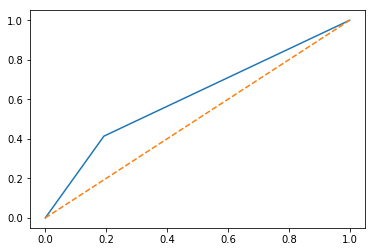

In [47]:
print(f"Log loss: {log_loss(y_test, y_pred_t)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_t[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_t[:,1])
#Plot
plt.plot(fpr, tpr)
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');

In [1]:
# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data, filled=True, rounded=True,special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### Decision Tree #2, after Graph Search

In [42]:
clf_2 = DecisionTreeClassifier()

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 5, 10],
    "min_samples_split": [1.0, 5, 10, 20]
}

gs_tree = GridSearchCV(clf_2, param_grid, cv=3)

gs_tree.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10], 'min_samples_split': [1.0, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
gs_tree.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}

In [44]:
best = gs_tree.best_params_

clf_2 = DecisionTreeClassifier(**best)
clf_2.fit(X_train, y_train)
y_pred_t2 = clf_2.predict_proba(X_test)

Log loss: 0.669049062919435

ROC AUC Score: 0.71574938782953


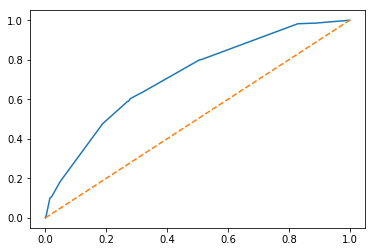

In [46]:
print(f"Log loss: {log_loss(y_test, y_pred_t2)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_t2[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_t2[:,1])
#Plot
plt.plot(fpr, tpr)
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');

In [ ]:
# print("Testing Accuracy for Grid Search Best Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, y_pred_t2) * 100))
# print(f"Testing Average Precision Score: {round(average_precision_score(y_test, y_pred_t2) * 100, 2)}%")
# print(classification_report(y_test, y_pred_t2))

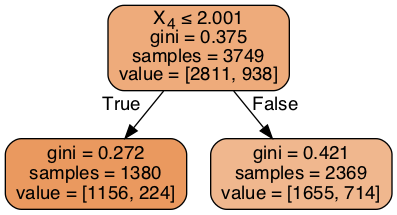

In [314]:
dot_data = StringIO()
export_graphviz(clf_2, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [164]:
# for i, x in enumerate(X.columns):
#     print(str(i) + ": " + x)

### Random Forest Classifier

In [26]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5)

forest.fit(X_train, y_train)

y_pred_forest = forest.predict_proba(X_test)
y_pred_f = forest.predict(X_test)

In [23]:
from sklearn.metrics import log_loss, roc_auc_score

Log loss: 0.5302181848306553

ROC AUC Score: 0.7668363160362613


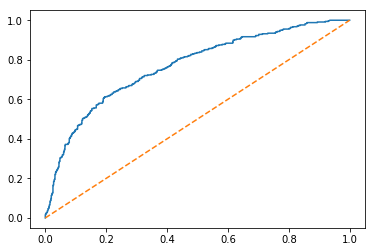

In [35]:
print(f"Log loss: {log_loss(y_test, y_pred_forest)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_forest[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_forest[:,1])
#Plot
plt.plot(fpr, tpr)
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');

In [62]:
# print("Testing Accuracy for Random Forrest Classifier: {:.4}%".format(accuracy_score(y_test, y_pred_forest) * 100))
# print(f"Testing Average Precision Score: {round(average_precision_score(y_test, y_pred_forest) * 100, 2)}%")
# print(classification_report(y_test, y_pred_forest))

### Gradient Boosting Classifier

In [37]:
boost = GradientBoostingClassifier(learning_rate=.01)

boost.fit(X_train, y_train)

boost_pred = boost.predict_proba(X_test)

Log loss: 0.5359928172784619

ROC AUC Score: 0.7390411717203292


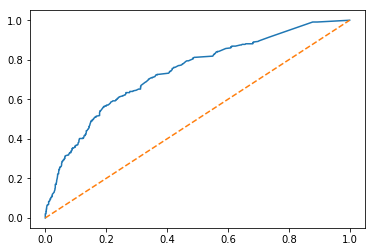

In [38]:
print(f"Log loss: {log_loss(y_test, boost_pred)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, boost_pred[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, boost_pred[:,1])
#Plot
plt.plot(fpr, tpr)
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');

In [ ]:
# print("Testing Accuracy for Gradient Boosting Classifier: {:.4}%".format(accuracy_score(y_test, boost_pred) * 100))
# print(f"Testing Average Precision Score: {round(average_precision_score(y_test, boost_pred) * 100, 2)}%")
# print(classification_report(y_test, boost_pred))

### XG Boost Classifier

In [ ]:
x_boost = xgb.XGBClassifier(learning_rate=.1)

x_boost.fit(X_train, y_train)

In [ ]:
x_pred = x_boost.predict_proba(X_test)

In [ ]:
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, x_pred) * 100))

print(classification_report(y_test, x_pred))